In [17]:
# ✅ Required Imports
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
import time
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix



# Data Description

In [19]:
df = pd.read_parquet('cybersecurity_threatscore.parquet', engine='pyarrow')

In [20]:
df.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [21]:
# Check the shape (rows, columns)
print(f"Dataset shape: {df.shape}")
# Output: Dataset shape: (10000, 15)  # Example output

Dataset shape: (2830743, 79)


In [22]:
pd.read_parquet('Cybersecurity_threatscore.parquet').dtypes

 Destination Port                int64
 Flow Duration                   int64
 Total Fwd Packets               int64
 Total Backward Packets          int64
Total Length of Fwd Packets      int64
                                ...   
Idle Mean                      float64
 Idle Std                      float64
 Idle Max                        int64
 Idle Min                        int64
 Label                          object
Length: 79, dtype: object

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830743 entries, 0 to 2830742
Data columns (total 79 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0    Destination Port             int64  
 1    Flow Duration                int64  
 2    Total Fwd Packets            int64  
 3    Total Backward Packets       int64  
 4   Total Length of Fwd Packets   int64  
 5    Total Length of Bwd Packets  int64  
 6    Fwd Packet Length Max        int64  
 7    Fwd Packet Length Min        int64  
 8    Fwd Packet Length Mean       float64
 9    Fwd Packet Length Std        float64
 10  Bwd Packet Length Max         int64  
 11   Bwd Packet Length Min        int64  
 12   Bwd Packet Length Mean       float64
 13   Bwd Packet Length Std        float64
 14  Flow Bytes/s                  float64
 15   Flow Packets/s               float64
 16   Flow IAT Mean                float64
 17   Flow IAT Std                 float64
 18   Flow IAT Max         

# Exploratory data analysis

In [24]:
# Load data and compute missing stats in one line
missing_stats = pd.read_parquet('Cybersecurity_threatscore.parquet').isnull().sum().to_frame(name='Missing Values').assign(Missing_Percentage=lambda x: (x['Missing Values'] / len(df)) * 100)

print(missing_stats)

                             Missing Values  Missing_Percentage
 Destination Port                         0                 0.0
 Flow Duration                            0                 0.0
 Total Fwd Packets                        0                 0.0
 Total Backward Packets                   0                 0.0
Total Length of Fwd Packets               0                 0.0
...                                     ...                 ...
Idle Mean                                 0                 0.0
 Idle Std                                 0                 0.0
 Idle Max                                 0                 0.0
 Idle Min                                 0                 0.0
 Label                                    0                 0.0

[79 rows x 2 columns]


In [25]:
# Check for "invisible" missing values (e.g., empty strings, placeholders)
print(df.isna().sum())  # Standard NaNs
print((df == '').sum())  # Empty strings
print((df == 'NULL').sum())  # Placeholder text

 Destination Port              0
 Flow Duration                 0
 Total Fwd Packets             0
 Total Backward Packets        0
Total Length of Fwd Packets    0
                              ..
Idle Mean                      0
 Idle Std                      0
 Idle Max                      0
 Idle Min                      0
 Label                         0
Length: 79, dtype: int64
 Destination Port              0
 Flow Duration                 0
 Total Fwd Packets             0
 Total Backward Packets        0
Total Length of Fwd Packets    0
                              ..
Idle Mean                      0
 Idle Std                      0
 Idle Max                      0
 Idle Min                      0
 Label                         0
Length: 79, dtype: int64
 Destination Port              0
 Flow Duration                 0
 Total Fwd Packets             0
 Total Backward Packets        0
Total Length of Fwd Packets    0
                              ..
Idle Mean                 

In [26]:
# Load data
df = pd.read_parquet('Cybersecurity_threatscore.parquet')

# Select numeric columns (for outlier analysis)
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

# Function to detect outliers
def detect_outliers(column):
    # IQR Method
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    iqr_outliers = column[(column < (Q1 - 1.5 * IQR)) | (column > (Q3 + 1.5 * IQR))]
    
    # Z-Score Method (for normally distributed data)
    z_scores = (column - column.mean()) / column.std()
    z_outliers = column[np.abs(z_scores) > 3]
    
    return {
        'IQR_Outliers_Count': len(iqr_outliers),
        'Z_Score_Outliers_Count': len(z_outliers),
        'IQR_Outliers_Values': iqr_outliers.values,
        'Z_Score_Outliers_Values': z_outliers.values
    }

# Check outliers for all numeric columns
outliers_report = {col: detect_outliers(df[col]) for col in numeric_cols}

# Print results
for col, stats in outliers_report.items():
    print(f"\nColumn: {col}")
    print(f"IQR Outliers Count: {stats['IQR_Outliers_Count']}")
    print(f"Z-Score Outliers Count: {stats['Z_Score_Outliers_Count']}")


Column:  Destination Port
IQR Outliers Count: 627245
Z-Score Outliers Count: 18377

Column:  Flow Duration
IQR Outliers Count: 532586
Z-Score Outliers Count: 87432

Column:  Total Fwd Packets
IQR Outliers Count: 332693
Z-Score Outliers Count: 280

Column:  Total Backward Packets
IQR Outliers Count: 308291
Z-Score Outliers Count: 275

Column: Total Length of Fwd Packets
IQR Outliers Count: 446972
Z-Score Outliers Count: 3213

Column:  Total Length of Bwd Packets
IQR Outliers Count: 619046
Z-Score Outliers Count: 245

Column:  Fwd Packet Length Max
IQR Outliers Count: 664214
Z-Score Outliers Count: 37906

Column:  Fwd Packet Length Min
IQR Outliers Count: 14958
Z-Score Outliers Count: 8246

Column:  Fwd Packet Length Mean
IQR Outliers Count: 188020
Z-Score Outliers Count: 34318

Column:  Fwd Packet Length Std
IQR Outliers Count: 663959
Z-Score Outliers Count: 33148

Column: Bwd Packet Length Max
IQR Outliers Count: 637112
Z-Score Outliers Count: 85246

Column:  Bwd Packet Length Min
IQR

In [27]:
# Example: Flag IQR-based outliers in 'Flow Duration'
Q1 = df[' Flow Duration'].quantile(0.25)
Q3 = df[' Flow Duration'].quantile(0.75)
IQR = Q3 - Q1
df['is_outlier_flow_duration'] = (df[' Flow Duration'] > (Q3 + 1.5 * IQR)) | (df[' Flow Duration'] < (Q1 - 1.5 * IQR))

In [28]:
print(df.columns.tolist())  # List all column names

[' Destination Port', ' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets', 'Total Length of Fwd Packets', ' Total Length of Bwd Packets', ' Fwd Packet Length Max', ' Fwd Packet Length Min', ' Fwd Packet Length Mean', ' Fwd Packet Length Std', 'Bwd Packet Length Max', ' Bwd Packet Length Min', ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s', ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean', ' Packet Length Std', ' Packet Length Variance', 'FIN Flag Count', ' SYN Flag Count', ' RST Flag Count', ' PSH Flag Count', ' ACK Flag Count', ' URG Flag 

C:\Users\HP\AppData\Local\Temp\ipykernel_4308\3564870660.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'outlier_{col}'] = ((df[col] < (Q1 - 1.5*IQR)) | (df[col] > (Q3 + 1.5*IQR)))
C:\Users\HP\AppData\Local\Temp\ipykernel_4308\3564870660.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'outlier_{col}'] = ((df[col] < (Q1 - 1.5*IQR)) | (df[col] > (Q3 + 1.5*IQR)))
C:\Users\HP\AppData\Local\Temp\ipykernel_4308\3564870660.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calli

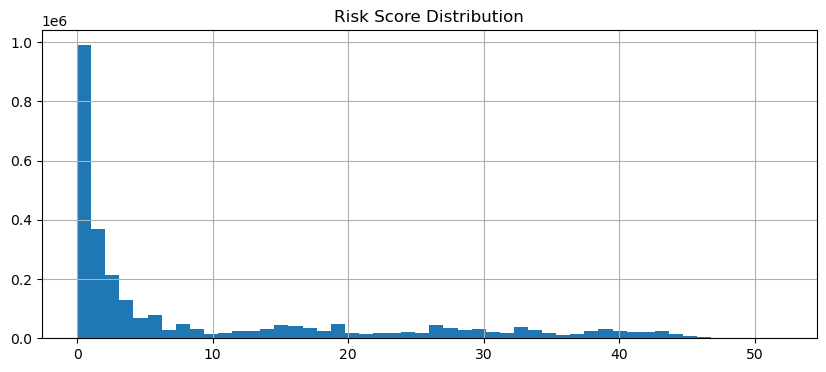

✅ Processing complete!
High-risk flows: 117984/2830743
Columns processed: [' Destination Port', ' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets', 'Total Length of Fwd Packets', ' Total Length of Bwd Packets', ' Fwd Packet Length Max', ' Fwd Packet Length Min', ' Fwd Packet Length Mean', ' Fwd Packet Length Std', 'Bwd Packet Length Max', ' Bwd Packet Length Min', ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s', ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean', ' Packet Length Std', ' Packet Length Variance', 'FIN Flag Count', ' SYN Flag Co

In [29]:
# Load your dataset
df = pd.read_parquet('Cybersecurity_threatscore.parquet')

# 1. Handle infinite values (replace with max/min finite values)
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
for col in numeric_cols:
    df[col] = df[col].replace([np.inf, -np.inf], np.nan)  # Convert inf to NaN
    max_val = df[col].max()  # Will ignore NaN by default
    min_val = df[col].min()
    df[col] = df[col].fillna(max_val if not np.isinf(max_val) else 0)  # Replace NaN

# 2. Flag outliers using IQR
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    df[f'outlier_{col}'] = ((df[col] < (Q1 - 1.5*IQR)) | (df[col] > (Q3 + 1.5*IQR)))

# 3. Create risk score
df['risk_score'] = df.filter(like='outlier_').sum(axis=1)

# 4. Scale features (now safe with no infinite values)
scaler = RobustScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# 5. Flag high-risk flows
df['high_risk'] = (df['risk_score'] > df['risk_score'].quantile(0.95)).astype(int)

# 6. Visualize
plt.figure(figsize=(10,4))
df['risk_score'].hist(bins=50)
plt.title('Risk Score Distribution')
plt.show()

print("✅ Processing complete!")
print(f"High-risk flows: {df['high_risk'].sum()}/{len(df)}")
print(f"Columns processed: {numeric_cols.tolist()}")

In [30]:
# Calculate outlier flags for all numeric columns
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    df[f'outlier_{col}'] = (df[col] < (Q1 - 1.5*IQR)) | (df[col] > (Q3 + 1.5*IQR))

# Create risk_score by summing outlier flags
df['risk_score'] = df.filter(like='outlier_').sum(axis=1)

plt.figure(figsize=(10, 6))
df['risk_score'].hist(bins=50, color='skyblue', edgecolor='black')
plt.title('Risk Score Distribution', fontsize=14)
plt.xlabel('Risk Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.savefig('risk_score_distribution.png', dpi=300, bbox_inches='tight')
plt.close()

C:\Users\HP\AppData\Local\Temp\ipykernel_4308\245644758.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'outlier_{col}'] = (df[col] < (Q1 - 1.5*IQR)) | (df[col] > (Q3 + 1.5*IQR))


Available columns: ['Destination Port', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'CWE Flag Coun

C:\Users\HP\AppData\Local\Temp\ipykernel_4308\3693448446.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=x, y=y, hue=hue, palette='Set2')


✅ Saved: destination_port_vs_risk_score_boxplot.png


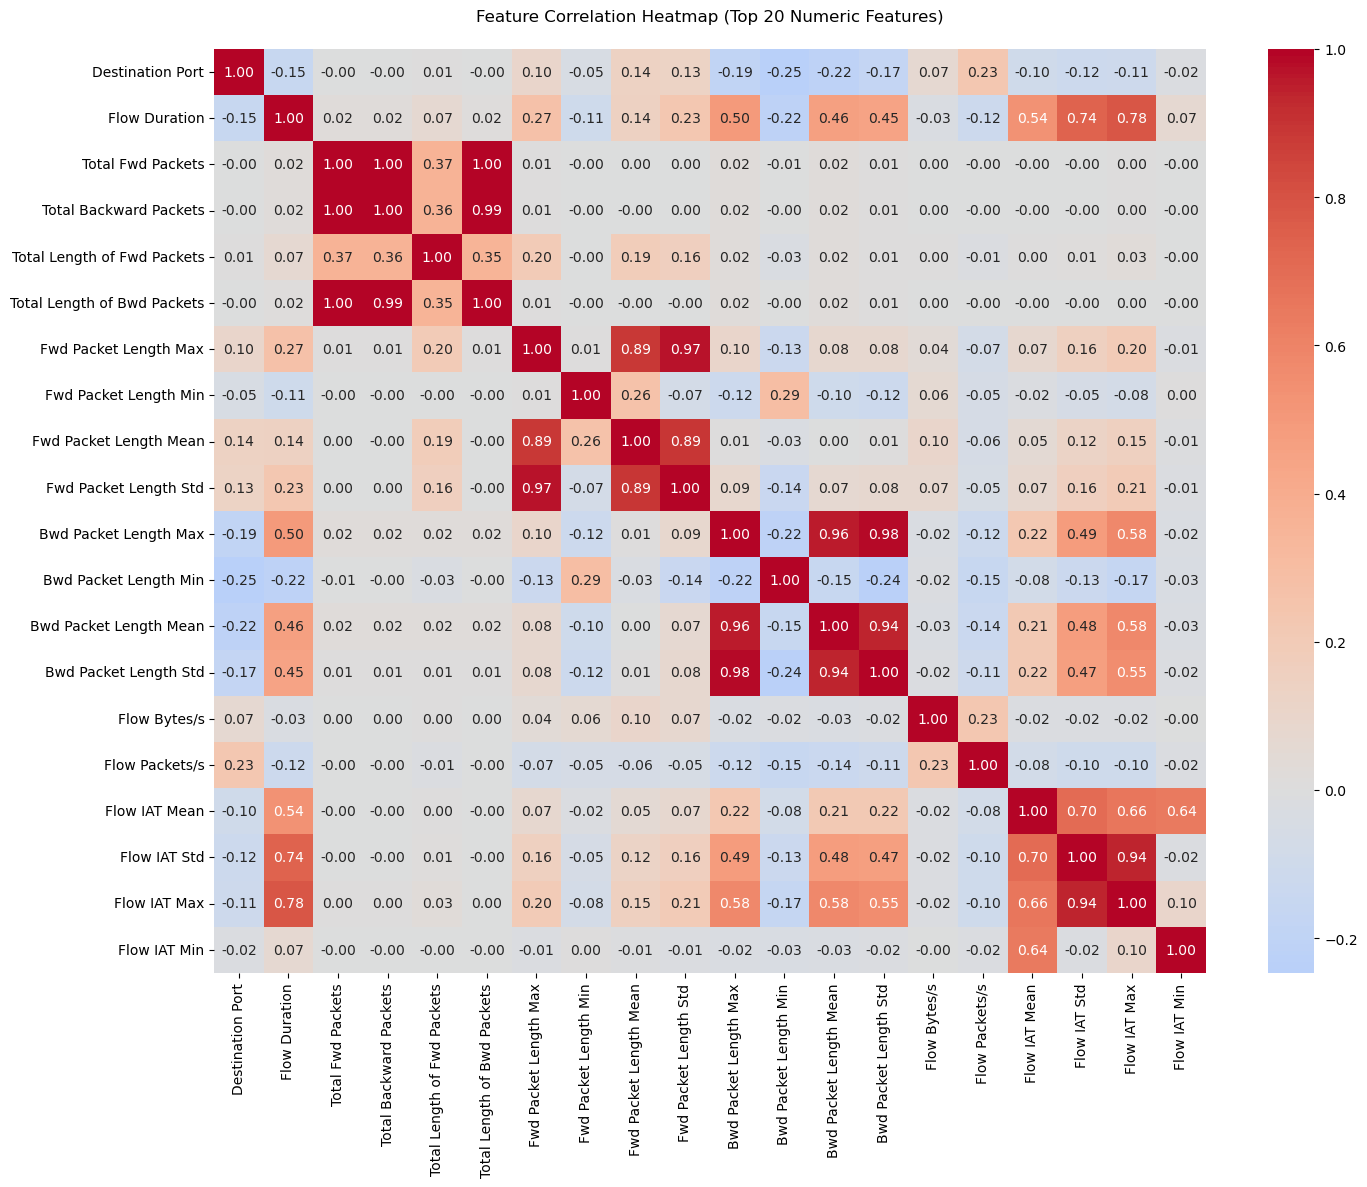

✅ Saved: correlation_heatmap.png

Analysis complete! Check your directory for:
- Scatter plot (flow_duration_vs_total_fwd_packets_scatter.png)
- Box plot (destination_port_vs_risk_score_boxplot.png)
- Correlation heatmap (correlation_heatmap.png)


In [31]:
# Load your dataset
df = pd.read_parquet('Cybersecurity_threatscore.parquet')

# 1. Clean column names (remove leading/trailing spaces)
df.columns = df.columns.str.strip()
print("Available columns:", df.columns.tolist())

# 2. Calculate Risk Score (if not already present)
if 'risk_score' not in df.columns:
    print("Calculating risk score...")
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    
    # Calculate IQR outliers for each numeric column
    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        df[f'outlier_{col}'] = (df[col] < (Q1 - 1.5*IQR)) | (df[col] > (Q3 + 1.5*IQR))
    
    # Sum outlier flags to create risk_score
    df['risk_score'] = df.filter(like='outlier_').sum(axis=1)
    
    # Create high_risk flag (top 5% of risk scores)
    df['high_risk'] = (df['risk_score'] > df['risk_score'].quantile(0.95)).astype(int)

# 3. Define your target columns (using columns we know exist)
target_columns = {
    'x': 'Flow Duration',        # Continuous variable
    'y': 'Total Fwd Packets',    # Continuous variable
    'hue': 'high_risk',          # Now we've created this
    'categorical': 'Destination Port'  # For boxplots
}

# 4. Bivariate Analysis with Auto-Saving
def safe_plot(df, x, y, hue=None, plot_type='scatter'):
    """Generate plots with error handling."""
    try:
        plt.figure(figsize=(10, 6))
        if plot_type == 'scatter':
            sns.scatterplot(data=df, x=x, y=y, hue=hue, alpha=0.7, palette='viridis')
        elif plot_type == 'boxplot':
            sns.boxplot(data=df, x=x, y=y, hue=hue, palette='Set2')
        
        title = f"{x} vs {y}" + (f" (by {hue})" if hue else "")
        plt.title(title, fontsize=14)
        plt.xticks(rotation=45)
        
        # Auto-generate filename
        filename = f"{x}_vs_{y}_{plot_type}.png".replace(" ", "_").replace("/", "_").lower()
        plt.savefig(filename, bbox_inches='tight', dpi=300)
        plt.close()
        print(f"✅ Saved: {filename}")
    except Exception as e:
        print(f"❌ Failed to plot {x} vs {y}: {str(e)}")

# Generate plots
safe_plot(df, target_columns['x'], target_columns['y'], target_columns['hue'], 'scatter')
safe_plot(df, target_columns['categorical'], 'risk_score', None, 'boxplot')

# 5. Correlation Heatmap (top 20 numeric features to avoid clutter)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()[:20]
if len(numeric_cols) > 1:
    plt.figure(figsize=(16, 12))
    corr = df[numeric_cols].corr()
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', center=0)
    plt.title("Feature Correlation Heatmap (Top 20 Numeric Features)", pad=20)
    plt.savefig("correlation_heatmap.png", bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()
    print("✅ Saved: correlation_heatmap.png")
else:
    print("⚠ Not enough numeric columns for correlation heatmap")

print("\nAnalysis complete! Check your directory for:")
print("- Scatter plot (flow_duration_vs_total_fwd_packets_scatter.png)")
print("- Box plot (destination_port_vs_risk_score_boxplot.png)")
print("- Correlation heatmap (correlation_heatmap.png)")

In [32]:
pip install tqdm


In [33]:
tqdm.pandas()


# Feature engineering

In [34]:
def superfast_feature_engineering_classification(df, target_column='Label', sample_frac=0.05, top_k_features=15):
    """
    Super-fast feature engineering for massive classification datasets
    """

    print("🚀 Superfast Feature Engineering for Classification Started...")
    total_start = time.time()

    # Step 1: Target Separation
    if target_column not in df.columns:
        raise ValueError(f"❗ Target column '{target_column}' not found in dataset!")

    y = df[target_column]
    X = df.drop(columns=[target_column])

    # Step 2: Sampling
    if 0 < sample_frac < 1.0:
        sample_idx = X.sample(frac=sample_frac, random_state=42).index
        X = X.loc[sample_idx]
        y = y.loc[sample_idx]
        print(f"✅ Sampled {sample_frac*100:.0f}% of the dataset ({X.shape[0]} rows).")

    # Step 3: Fill NaNs and Replace inf
    X = X.fillna(X.median(numeric_only=True))
    X = X.replace([np.inf, -np.inf], np.nan).fillna(0)

    # Step 4: Encode categorical columns carefully
    cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
    if cat_cols:
        if len(cat_cols) > 10:
            print(f"⚠️ Skipping full dummy encoding (too many categories). Encoding as labels instead.")
            for col in cat_cols:
                X[col] = X[col].astype('category').cat.codes
        else:
            X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

    # Step 5: Scaling
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

    # Step 6: Feature Selection (Classification Score)
    k = min(top_k_features, X_scaled.shape[1])
    selector = SelectKBest(score_func=mutual_info_classif, k=k)
    X_selected = selector.fit_transform(X_scaled, y)
    selected_features = X_scaled.columns[selector.get_support()]

    # Step 7: Final Output
    final_df = pd.DataFrame(X_selected, columns=selected_features, index=X.index)
    final_df[target_column] = y.values

    total_end = time.time()
    print(f"🏁 Completed in {total_end - total_start:.2f} seconds!")

    print(f"🎯 Top {len(selected_features)} Features Selected: {selected_features.tolist()}")
    return final_df


In [36]:
# Fast feature engineering on 5% sample first!
final_df = superfast_feature_engineering_classification(
    df,
    target_column='Label',
    sample_frac=0.05,      # 5% sampling first
    top_k_features=15
)

# View output
final_df.head()


🚀 Superfast Feature Engineering for Classification Started...
✅ Sampled 5% of the dataset (141537 rows).
🏁 Completed in 175.10 seconds!
🎯 Top 15 Features Selected: ['Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Max', 'Bwd Packet Length Max', 'Bwd Packet Length Mean', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'Average Packet Size', 'Avg Bwd Segment Size', 'Subflow Fwd Bytes', 'Subflow Bwd Bytes', 'Init_Win_bytes_forward', 'Init_Win_bytes_backward']


,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Bwd Packet Length Max,Bwd Packet Length Mean,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,Average Packet Size,Avg Bwd Segment Size,Subflow Fwd Bytes,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,Label
746827,-0.095244,-0.007497,-0.291925,-0.445668,-0.504201,-0.466993,-0.561168,-0.465260,-0.292737,-0.576947,-0.504201,-0.095244,-0.007497,-0.461574,3.660349,BENIGN
946912,-0.083122,-0.007338,-0.243863,-0.347745,-0.189465,-0.372912,-0.244985,-0.329537,-0.288304,-0.212929,-0.189465,-0.083122,-0.007338,-0.486505,-0.234164,BENIGN
2216843,-0.038732,-0.002662,0.156179,2.539421,2.239680,2.400984,1.737086,1.978841,1.144836,1.672107,2.239680,-0.038732,-0.002662,-0.467354,-0.206171,DoS Hulk
699389,-0.070286,-0.007425,-0.242450,-0.401345,-0.361742,-0.424409,-0.398578,-0.425731,-0.292361,-0.402238,-0.361742,-0.070286,-0.007425,-0.486505,-0.234164,BENIGN
1170268,-0.079556,-0.007427,-0.229727,-0.402891,-0.366711,-0.425895,-0.365685,-0.431329,-0.292460,-0.351890,-0.366711,-0.079556,-0.007428,-0.486505,-0.234164,BENIGN


In [39]:
print(df['Label'].unique())


['BENIGN' 'DDoS' 'PortScan' 'Bot' 'Infiltration'
 'Web Attack � Brute Force' 'Web Attack � XSS'
 'Web Attack � Sql Injection' 'FTP-Patator' 'SSH-Patator' 'DoS slowloris'
 'DoS Slowhttptest' 'DoS Hulk' 'DoS GoldenEye' 'Heartbleed']


In [41]:
# Assuming final_df is your feature-engineered dataset
X = final_df.drop(columns=['Label'])  # Features
y = final_df['Label']                 # Target

# Split 80% for training, 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(X_train.shape, X_test.shape)


(113229, 15) (28308, 15)


# Training the model with Random Forest using 5% of the dataset

In [43]:
# Create and train model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [45]:
y_pred = rf_model.predict(X_test)


In [47]:
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                          precision    recall  f1-score   support

                  BENIGN       1.00      1.00      1.00     22744
                     Bot       1.00      0.68      0.81        19
                    DDoS       1.00      1.00      1.00      1268
           DoS GoldenEye       0.99      0.96      0.98       103
                DoS Hulk       0.99      1.00      1.00      2308
        DoS Slowhttptest       0.68      0.96      0.79        52
           DoS slowloris       0.93      0.73      0.82        59
             FTP-Patator       1.00      1.00      1.00        82
                PortScan       0.99      1.00      0.99      1600
             SSH-Patator       1.00      0.96      0.98        54
Web Attack � Brute Force       0.00      0.00      0.00        13
        Web Attack � XSS       0.00      0.00      0.00         6

                accuracy                           1.00     28308
               macro avg       0.80      0.77      0.78     28308
        

# Training the model with Random Forest, XGBoost, LightGBM

In [53]:
# Encode labels for models that require numeric labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Update training models dictionary
models = {
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=100, random_state=42, verbosity=0),
    "LightGBM": LGBMClassifier(n_estimators=100, random_state=42, verbose=-1)
}

model_performance = {}

for name, model in models.items():
    print(f"\n🚀 Training {name}...")
    if name == "RandomForest":
        model.fit(X_train, y_train)  # RandomForest can handle string labels
        y_pred = model.predict(X_test)
    else:
        model.fit(X_train, y_train_encoded)  # XGBoost and LightGBM need encoded labels
        y_pred = model.predict(X_test)
        y_pred = label_encoder.inverse_transform(y_pred)  # Decode predictions back to original labels
    
    acc = accuracy_score(y_test, y_pred)
    print(f"✅ {name} Accuracy: {acc:.4f}")
    
    # Save performance
    model_performance[name] = (acc, model)

# ✅ Select Best Model
best_model_name = max(model_performance, key=lambda k: model_performance[k][0])
best_acc, best_model = model_performance[best_model_name]

print(f"\n🏆 Best Model: {best_model_name} with Accuracy: {best_acc:.4f}")

# ✅ Save Best Model
model_save_path = f"{best_model_name}_best_model.pkl"
joblib.dump(best_model, model_save_path)
print(f"✅ Best model saved successfully at '{model_save_path}'")



🚀 Training RandomForest...
✅ RandomForest Accuracy: 0.9965

🚀 Training XGBoost...
✅ XGBoost Accuracy: 0.9957

🚀 Training LightGBM...
✅ LightGBM Accuracy: 0.8022

🏆 Best Model: RandomForest with Accuracy: 0.9965
✅ Best model saved successfully at 'RandomForest_best_model.pkl'


# Training the model using 10% of the dataset

In [55]:
# ✅ Install necessary libraries if needed
!pip install scikit-learn joblib --quiet

# ✅ Step 1: Sample 10% of the full dataset
sampled_df = final_df.sample(frac=0.10, random_state=42)
print(f"Sampled dataset shape: {sampled_df.shape}")

# ✅ Step 2: Split into X and y
X = sampled_df.drop(columns=['Label'])
y = sampled_df['Label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")

# ✅ Step 3: Define Random Forest and Hyperparameter Space
rf_model = RandomForestClassifier(random_state=42)

param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

# ✅ Step 4: Randomized Search CV
random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=20,        # Try 20 different combinations
    cv=3,             # 3-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1         # Use all CPU cores
)

print("\n🚀 Starting Hyperparameter Tuning (RandomizedSearchCV)...")
random_search.fit(X_train, y_train)

print("\n🏆 Best Hyperparameters Found:")
print(random_search.best_params_)

# ✅ Step 5: Evaluate Best Model
best_rf_model = random_search.best_estimator_

y_pred = best_rf_model.predict(X_test)

print("\n📊 Model Performance on Test Set:")
print(classification_report(y_test, y_pred))
print(f"✅ Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")

# ✅ Step 6: Save Best Model
model_save_path = "RandomForest_best_model_step2.pkl"
joblib.dump(best_rf_model, model_save_path)
print(f"\n✅ Tuned RandomForest model saved at: '{model_save_path}'")


Sampled dataset shape: (14154, 16)
Training set: (11323, 15), Test set: (2831, 15)

🚀 Starting Hyperparameter Tuning (RandomizedSearchCV)...
Fitting 3 folds for each of 20 candidates, totalling 60 fits


C:\Users\HP\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(



🏆 Best Hyperparameters Found:
{'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None, 'bootstrap': False}

📊 Model Performance on Test Set:
                          precision    recall  f1-score   support

                  BENIGN       1.00      1.00      1.00      2288
                     Bot       1.00      1.00      1.00         2
                    DDoS       0.98      1.00      0.99       125
           DoS GoldenEye       0.83      0.91      0.87        11
                DoS Hulk       0.99      1.00      0.99       221
        DoS Slowhttptest       0.62      0.83      0.71         6
           DoS slowloris       1.00      0.50      0.67         6
             FTP-Patator       0.90      1.00      0.95         9
                PortScan       1.00      0.99      1.00       156
             SSH-Patator       1.00      1.00      1.00         5
Web Attack � Brute Force       0.00      0.00      0.00         1
        We

C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Training the model on full feature-engineered dataset

In [63]:
# ✅ Step 1: Load full feature-engineered dataset
# Assuming final_df is already loaded and ready

# ✅ Step 2: Split into features (X) and target (y)
X_full = final_df.drop(columns=['Label'])
y_full = final_df['Label']

print(f"✅ Full dataset shape: {X_full.shape}")

# ✅ Step 3: Correct Best Hyperparameters from Step 2
best_params = {
    'n_estimators': 200,
    'min_samples_split': 5,
    'min_samples_leaf': 1,
    'max_features': 'log2',
    'max_depth': None,
    'bootstrap': False,
    'random_state': 42
}

# ✅ Step 4: Train Final RandomForest Model
print("\n🚀 Training Final RandomForest on Full Data with Best Hyperparameters...")
final_rf_model = RandomForestClassifier(**best_params)
final_rf_model.fit(X_full, y_full)

print("\n✅ Final Model Trained Successfully!")

# ✅ Step 5: Save the Final Trained Model
joblib.dump(final_rf_model, "RandomForest_final_model.pkl")
print("\n✅ Final RandomForest model saved at: 'RandomForest_final_model.pkl'")

# ✅ Step 6 (Optional but Recommended): Save Feature List
feature_list = list(X_full.columns)
joblib.dump(feature_list, "RandomForest_feature_list.pkl")
print("\n✅ Feature list saved at: 'RandomForest_feature_list.pkl'")


✅ Full dataset shape: (141537, 15)

🚀 Training Final RandomForest on Full Data with Best Hyperparameters...

✅ Final Model Trained Successfully!

✅ Final RandomForest model saved at: 'RandomForest_final_model.pkl'

✅ Feature list saved at: 'RandomForest_feature_list.pkl'


✅ Test set shape: (14154, 15)

🏆 Final Model Performance on Test Set:


C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                          precision    recall  f1-score   support

                  BENIGN       1.00      1.00      1.00     11372
                     Bot       1.00      0.70      0.82        10
                    DDoS       1.00      1.00      1.00       634
           DoS GoldenEye       0.98      0.98      0.98        52
                DoS Hulk       1.00      1.00      1.00      1154
        DoS Slowhttptest       0.74      1.00      0.85        26
           DoS slowloris       1.00      0.86      0.93        29
             FTP-Patator       1.00      1.00      1.00        41
                PortScan       0.99      1.00      0.99       800
             SSH-Patator       1.00      1.00      1.00        27
Web Attack � Brute Force       0.00      0.00      0.00         6
        Web Attack � XSS       0.00      0.00      0.00         3

                accuracy                           1.00     14154
               macro avg       0.81      0.79      0.80     14154
        

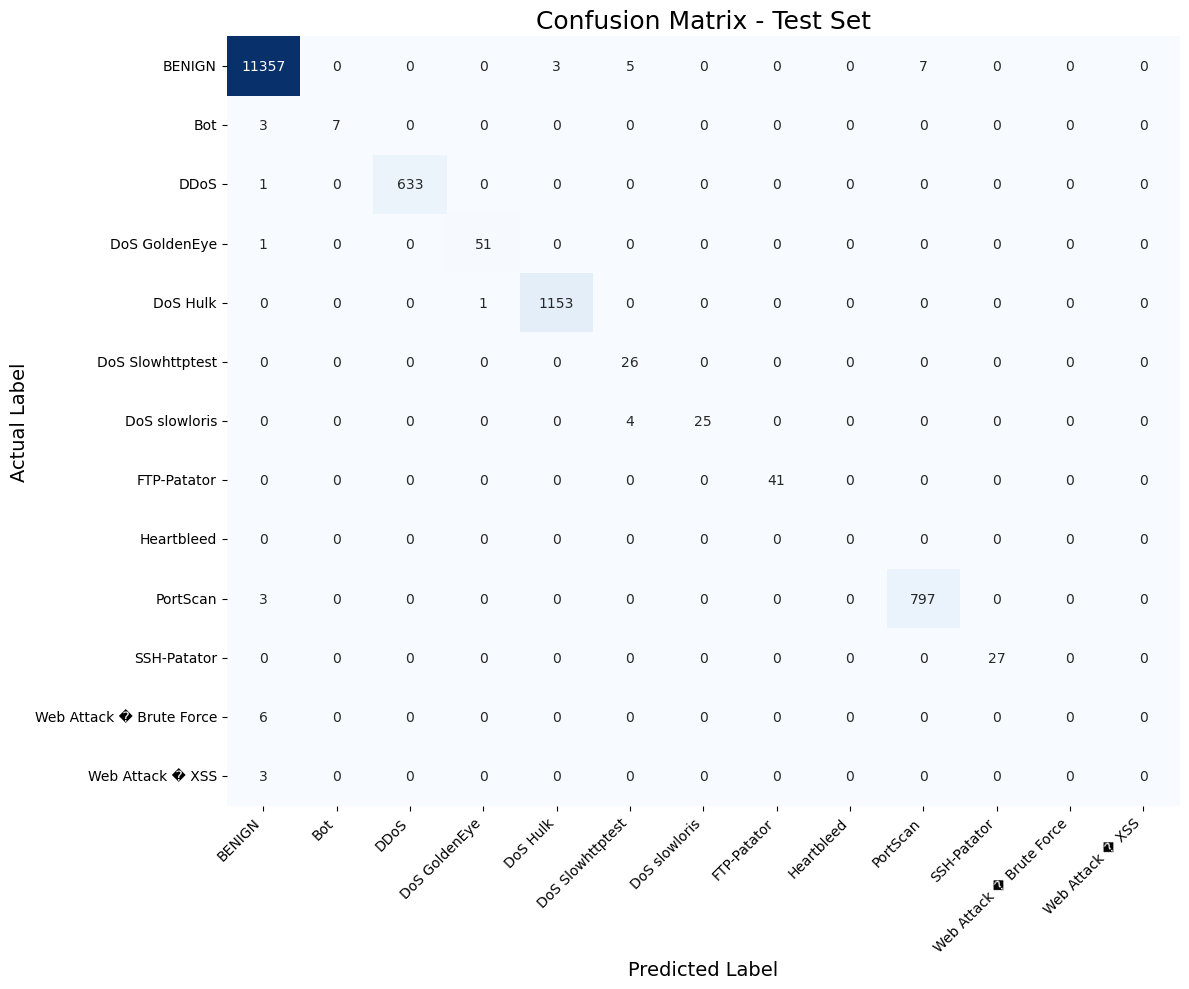

In [71]:
# ✅ Step 1: Reload your saved model and feature list
model = joblib.load("RandomForest_final_model.pkl")
feature_list = joblib.load("RandomForest_feature_list.pkl")

# ✅ Step 2: Prepare the Test Set
# Assuming your full processed data is still 'final_df'
X = final_df.drop(columns=['Label'])
y = final_df['Label']

# Fresh train-test split (e.g., 90% train, 10% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.10, random_state=42, stratify=y
)

print(f"✅ Test set shape: {X_test.shape}")

# ✅ Step 3: Predict on Test Set
y_pred = model.predict(X_test)

# ✅ Step 4: Evaluation Metrics
print("\n🏆 Final Model Performance on Test Set:")
print(classification_report(y_test, y_pred))
test_accuracy = accuracy_score(y_test, y_pred)
print(f"✅ Test Accuracy: {test_accuracy:.4f}")

# ✅ Step 5: Confusion Matrix and Save as Image
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))
cm_df = pd.DataFrame(cm, index=np.unique(y), columns=np.unique(y))

plt.figure(figsize=(12, 10))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix - Test Set", fontsize=18)
plt.ylabel("Actual Label", fontsize=14)
plt.xlabel("Predicted Label", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

# Save confusion matrix as image
plt.savefig("confusion_matrix_test_set.png")
print("\n✅ Confusion Matrix saved as 'confusion_matrix_test_set.png'")
plt.show()
